In [1]:
import pandas as pd
import torch
import torch.nn as nn
import shap
import joblib

# 1. SHAP analysis

In [2]:
# Import training and testing sets
X_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_train.csv")
X_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_validate.csv")
X_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_test.csv")
y_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_train.csv").squeeze()
y_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_validate.csv").squeeze()
y_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_test.csv").squeeze()

In [ ]:

# Load scaler
scaler = joblib.load("/home/s2106664/msc_project/model_training/scaler.pkl")

# Features to scale (same as training)
scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                   "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]

X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Convert to tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)

# Load model
input_dim = X_test_tensor.shape[1]
model = MLP(input_dim=input_dim)
model.load_state_dict(torch.load("/home/s2106664/msc_project/model_training/best_mlp_sigmoid_model.pth"))
model.eval()


def model_wrapper(x_numpy):
    x_tensor = torch.from_numpy(x_numpy.astype(np.float32)).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.sigmoid(logits)  # Convert logits to probabilities
    return probs.cpu().numpy()

SHAP values shape: (14900, 78, 1)


/tmp/ipykernel_4000796/102132179.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_samples.numpy(), feature_names=X_test_scaled.columns)
/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


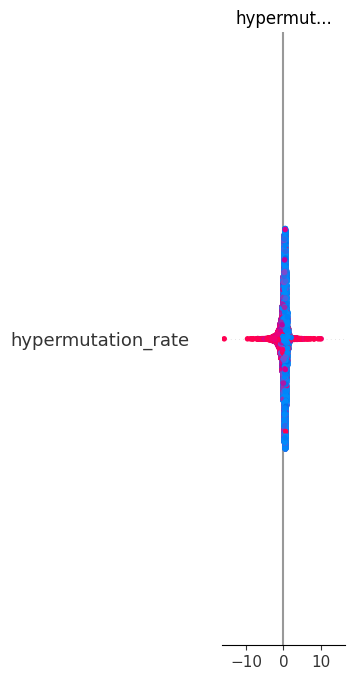

In [8]:
model.eval()
model.cpu()

# Use first 100 samples as background
background = X_test_tensor[:100].cpu()

# Select 50 samples to explain
test_samples = X_test_tensor[100:15000].cpu()

# Create SHAP GradientExplainer directly on model and background
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for test samples
shap_values = explainer.shap_values(test_samples)

print(f"SHAP values shape: {shap_values.shape}")  # (50, number_of_features)

# Plot summary
shap.summary_plot(shap_values, test_samples.numpy(), feature_names=X_test_scaled.columns)


In [11]:
explainer = shap.Explainer(model, X_test_tensor[100:1500])
shap_values = explainer(X_test_tensor[100:1500])

TypeError: 'Tensor' object is not callable